In [1]:
#Import libraries

import os
import xarray as xr
import numpy as np
import pandas as pd
import calendar
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Functions definitions

In [2]:
# Functions for extract meteorological variables

def drop_steps(ds):
    # It drops the step coordinate of the DataSet ds. It returns a hourly distributed DataSet .
    
    start_date = (ds.time[0]).values + pd.Timedelta(hours = 6)
    last_date = (ds.time[-1]).values + pd.Timedelta(hours = 5)
    lat = ds.latitude.values
    lon = ds.longitude.values
    time_range = pd.date_range(start = start_date, end = last_date, freq = 'H')
    arr = ds.values
    arr = arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2], arr.shape[3])
    arr = arr[6:-6, :, :]
    ds = xr.Dataset(
        data_vars = dict(
            variable = (['time', 'latitude', 'longitude'], arr)
        ), 
        coords = dict(
            time = time_range, 
            latitude = lat, 
            longitude = lon, 
        ), 
    )
    return ds

def in_coords(ds, coords):
    #It returns an array with the meteo values of the corresponding coordinates
    c = 0
    for c in range(len(coords)):
        aux = ((ds.sel(latitude = coords[c][0], longitude = coords[c][1], method='nearest')).values)
        aux = np.array(aux)
        aux = np.reshape(aux, (-1, 1))
        if c == 0:
            arr = arr = np.array(aux)
        else:
            arr = np.append(arr, aux, axis=1)
            
        c+=1
    return arr

def data_base_hourly_by_year(init_year, last_year, variable, coords):
    #Main fuction to extract the meteorological variables given initial and last year, variable and coordinates
    for i in range(init_year, last_year+1):
        ds = xr.open_dataset(meteopath+str(variable)+'/'+str(variable)+'_' + str(i) + '.nc')
        ds = getattr(ds, variable)
        # ds = drop_steps(getattr(ds, variable))
        

        if i == init_year:
            arr = in_coords(ds, coords)
            time=ds.time
        else:
            arr = np.append(arr, in_coords(ds, coords), axis=0)
            time= np.append(time, ds.time, axis=0) 
        print(arr.shape)
    return arr,time

# Functions for data preprocessing

def divide_variables(train,test,Y_column,scale=1):    
    #Divide variables between X and Y and scale them    
    
    feature_cols=train.columns.drop([Y_column])    
     
    X_train=train[feature_cols]
    Y_train=train[Y_column]
    
    X_test=test[feature_cols]
    Y_test=test[Y_column]
    

    if scale==1:                              #Standard scaling              
        from sklearn import preprocessing
        scaler = preprocessing.StandardScaler()
        X_std_train = scaler.fit(X_train)

        X_std_train = scaler.transform(X_train)
        X_std_test = scaler.transform(X_test)

        X_train=pd.DataFrame(X_std_train,columns=X_train.columns,index=X_train.index)
        X_test=pd.DataFrame(X_std_test,columns=X_test.columns,index=X_test.index)

    elif scale==2:                            #Normalization
        from sklearn import preprocessing
        scaler = preprocessing.Normalizer()
        X_std_train = scaler.fit(X_train)

        X_std_train = scaler.transform(X_train)
        X_std_test = scaler.transform(X_test)

        X_train=pd.DataFrame(X_std_train,columns=X_train.columns,index=X_train.index)
        X_test=pd.DataFrame(X_std_test,columns=X_test.columns,index=X_test.index)
    
    return X_train,Y_train,X_test,Y_test

def set_3std(train_set,test_set,Y_column):
    # Returns the test samples above the mean+3std and its indexes
    rows=test_set.index
    test_set_out=test_set
    ind=[]
    for row in range (0,len(rows)):
        if test_set[Y_column][row]>(np.mean(train_set[Y_column])+3*np.std(train_set[Y_column])):
            ind.append(row)
    test_set_3std=test_set.iloc[ind]
    return test_set_3std,ind

# Functions for error metrics calculation

def Relevance(train_set,test_set,Y_column):
    # Set a relevance value for each test sample

    # Linear Relevance Function
    R_test_lineal=(1/(np.max(train_set[Y_column])-np.min(train_set[Y_column])))*test_set[Y_column]
    R_test_lineal[R_test_lineal>1]=1
    
    # Intervallic Relevance Function
    R_test_inter=[]
    for i in range(0,test_set.shape[0]):
        if 0<=test_set[Y_column][i]<np.mean(train_set[Y_column]):
            R_test_inter.append(0.1)
        elif np.mean(train_set[Y_column])<=test_set[Y_column][i]<np.mean(train_set[Y_column])+1*np.std(train_set[Y_column]):
            R_test_inter.append(0.25)
        elif np.mean(train_set[Y_column])+1*np.std(train_set[Y_column])<=test_set[Y_column][i]<np.mean(train_set[Y_column])+2*np.std(train_set[Y_column]):
            R_test_inter.append(0.4)
        elif np.mean(train_set[Y_column])+2*np.std(train_set[Y_column])<=test_set[Y_column][i]<np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]):
            R_test_inter.append(0.55)
        elif np.mean(train_set[Y_column])+3*np.std(train_set[Y_column])<=test_set[Y_column][i]<np.mean(train_set[Y_column])+4*np.std(train_set[Y_column]):
            R_test_inter.append(0.6)
        elif np.mean(train_set[Y_column])+4*np.std(train_set[Y_column])<=test_set[Y_column][i]<np.mean(train_set[Y_column])+5*np.std(train_set[Y_column]):
            R_test_inter.append(0.75)
        elif np.mean(train_set[Y_column])+5*np.std(train_set[Y_column])<=test_set[Y_column][i]:
            R_test_inter.append(0.9)

    # Cubic Relevance Function
    R_test_cubic=(0-1*(np.min(train_set[Y_column])**3)/(np.max(train_set[Y_column])**3-np.min(train_set[Y_column])**3))+1*(test_set[Y_column]**3)/(np.max(train_set[Y_column])**3-np.min(train_set[Y_column])**3)
    R_test_cubic[R_test_cubic>1]=1

    # Sigmoid Relevance Function
    c=np.mean(train_set[Y_column])+2*np.std(train_set[Y_column])
    s=np.log(0.0001**(-1)-1)/(np.abs(c*0.5))
    R_sigmoid=1/(1+np.exp(-s*(test_set[Y_column]-c)))
    return R_test_lineal,R_test_inter,R_test_cubic,R_sigmoid

def MAE_pondered(Y, Y_pred,R):
    # Calculate the Case Weighted MAE given a Relevance function
    sum=0
    sumR=0
    for i in range(0,Y.shape[0]):
        sum+=np.abs(Y[i]-Y_pred[i])*R[i]
        sumR+=R[i]
    return sum/sumR

def false_positive_rate(Y,Y_pred):
    #Computes the False Positive Rate
    False_positive=0
    Negative=0
    for i in range(0,len(Y_pred)):
        if Y_pred[i]>np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]) and Y[i]<=np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]):
            False_positive+=1
        if Y[i]<=np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]):
            Negative+=1
    return False_positive/Negative

def ge_mean(Y,Y_pred):
    # Returns the G_mean and the Recall
    Positive=0
    True_positive=0
    Negative=0
    True_negative=0
    for i in range(0,len(Y_pred)):
        if Y[i]>np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]):
            Positive+=1
        if Y_pred[i]>np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]) and Y[i]>np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]):
            True_positive+=1
        if Y[i]<=np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]):
            Negative+=1
        if Y_pred[i]<=np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]) and Y[i]<=np.mean(train_set[Y_column])+3*np.std(train_set[Y_column]):
            True_negative+=1
    Recall=True_positive/Positive
    Specificity=True_negative/Negative
    return Recall,np.sqrt(Recall*Specificity)

def errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid):
    # Calculates error metrics
    from sklearn.metrics import mean_absolute_error

    mae = mean_absolute_error(Y_test, Y_pred)
    mae_3std=mean_absolute_error(Y_test_3std,Y_pred_3std)
    mae_pondered_lineal=MAE_pondered(Y_test, Y_pred,R_test_lineal)
    mae_pondered_inter=MAE_pondered(Y_test, Y_pred,R_test_inter)
    mae_pondered_cubic=MAE_pondered(Y_test, Y_pred,R_test_cubic)
    mae_pondered_sigmoid=MAE_pondered(Y_test, Y_pred,R_test_sigmoid)
    mae_pondered_mean=np.mean([mae_pondered_lineal,mae_pondered_inter,mae_pondered_cubic,mae_pondered_sigmoid])
    false_pos_rate=false_positive_rate(Y_test,Y_pred)
    rec,gm=ge_mean(Y_test,Y_pred)
    # print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
    
    return mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm

# Functions for running ML models and get results

def figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, title):
    
    # Figure 1: Actual test values vs Predicted test values    
    plt.figure(figsize=(20, 6))
    style.use('default')
    plt.rcParams['font.family'] = ['sans-serif']
    plt.plot(np.arange(len(Y_test)),Y_test,'blue', label='Actual Value')
    plt.plot(np.arange(len(Y_test)),Y_pred,'red', label='Estimated Value')
    plt.title(title)
    plt.legend()
    plt.ylabel("Deviation",fontsize=20)
    plt.xlabel("Samples(Hours)",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    plt.xlim([0,len(test_set)])
    plt.show()
    # Figure 2: First 3000 actual test values vs First 3000 predicted test values  
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(len(Y_test))[0:3000],Y_test[0:3000],'blue', label='Actual Value')
    plt.plot(np.arange(len(Y_test))[0:3000],Y_pred[0:3000],'red', label='Estimated Value')
    plt.title(title)
    plt.legend()
    plt.ylabel("Deviation",fontsize=20)
    plt.xlabel("Samples(Hours)",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    plt.xlim([0,3000])
    plt.show()
    # Figure 3: Actual test extremes values vs Predicted test extremes values  
    plt.figure(figsize=(20, 6))
    plt.title(title+'_3std')
    plt.scatter(ind,Y_test_3std,color='blue', label='Actual Value')
    plt.scatter(ind,Y_pred_3std,color='red', label='Estimated Value')
    plt.legend()
    plt.ylabel("Deviation",fontsize=20)
    plt.xlabel("Samples(Hours)",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    plt.xlim([0,len(test_set)])
    plt.show()  

def evaluate_ML_methods(X_train,Y_train,X_test,Y_test,X_test_3std,Y_test_3std):
    #Evaluate the ML methods, it prints the error metrics and the figures

    #Linear Reg
    from sklearn.linear_model import LinearRegression
    lm=LinearRegression()
    lm.fit(X_train,Y_train)
    Y_pred=lm.predict(X_test)
    for i in range(0,len(Y_pred)):
        if Y_pred[i]<0:
            Y_pred[i]=0
    Y_pred_3std=lm.predict(X_test_3std)
    for i in range(0,len(Y_pred_3std)):
        if Y_pred_3std[i]<0:
            Y_pred_3std[i]=0
    print('\nLinear Reg:')
    mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
    print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
    figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "Linear Reg")

    #Reg Tree
    from sklearn.tree import DecisionTreeRegressor
    tree_reg = DecisionTreeRegressor(max_depth=400)
    tree_reg.fit(X_train,Y_train)
    Y_pred=tree_reg.predict(X_test)
    for i in range(0,len(Y_pred)):
        if Y_pred[i]<0:
            Y_pred[i]=0
    Y_pred_3std=tree_reg.predict(X_test_3std)
    for i in range(0,len(Y_pred_3std)):
        if Y_pred_3std[i]<0:
            Y_pred_3std[i]=0
    print('\nRegression Trees:')
    mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
    print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
    figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "Regression Trees")

    #Random Forest
    from sklearn.ensemble import RandomForestRegressor
    forest_reg = RandomForestRegressor(n_estimators=400)
    forest_reg.fit(X_train,Y_train)
    Y_pred=forest_reg.predict(X_test)
    for i in range(0,len(Y_pred)):
        if Y_pred[i]<0:
            Y_pred[i]=0
    Y_pred_3std=forest_reg.predict(X_test_3std)
    for i in range(0,len(Y_pred_3std)):
        if Y_pred_3std[i]<0:
            Y_pred_3std[i]=0
    print('\nRandom Forest:')
    mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
    print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
    figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "Random Forest")

    # MLP
    import tensorflow as tf

    from tensorflow import keras
    from tensorflow.keras import layers

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(X_train))

    def build_and_compile_model(norm):
        model = keras.Sequential([
            norm,
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])

        model.compile(loss='mean_absolute_error',
                        optimizer=tf.keras.optimizers.Adam(0.001))
        return model

    dnn_model = build_and_compile_model(normalizer)
    # dnn_model.summary()

    #%%time
    history = dnn_model.fit(
        X_train,
        Y_train,
        validation_split=0.2,
        verbose=0, epochs=100)

    
    Y_pred=dnn_model.predict(X_test)
    for i in range(0,len(Y_pred)):
        if Y_pred[i]<0:
            Y_pred[i]=0
    Y_pred_3std=dnn_model.predict(X_test_3std)
    for i in range(0,len(Y_pred_3std)):
        if Y_pred_3std[i]<0:
            Y_pred_3std[i]=0
    print('\nMLP:')
    mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
    print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
    figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "MLP")

    #ELM
    from scipy.linalg import pinv

    input_size = len(X_train.columns)
    hidden_size = 500
    input_weights = np.random.normal(size=[input_size,hidden_size])
    biases = np.random.normal(size=[hidden_size])
    def relu(x):
        return np.maximum(x, 0, x)

    def hidden_nodes(X):
        G = np.dot(X, input_weights)
        G = G + biases
        H = relu(G)
        return H

    output_weights = np.dot(pinv(hidden_nodes(X_train)), Y_train)

    def predict(X):
        out = hidden_nodes(X)
        out = np.dot(out, output_weights)
        return out

    Y_pred=predict(X_test)
    for i in range(0,len(Y_pred)):
        if Y_pred[i]<0:
            Y_pred[i]=0
    Y_pred_3std=predict(X_test_3std)
    for i in range(0,len(Y_pred_3std)):
        if Y_pred_3std[i]<0:
            Y_pred_3std[i]=0
    print('\nELM:')
    mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
    print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
    figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "ELM")
      
def evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column,scale=1):
    #Classifiers are evaluated with the unbalanced and balanced data. It is used in the HCR methods
    
    #Function returns the trained classifiers and the G-mean values

    Outlier_test=np.array(Outlier_test)

    from sklearn import metrics
    from imblearn.metrics import geometric_mean_score

    #Scale data
    from sklearn import preprocessing
    scaler = preprocessing.StandardScaler()
    X_std_train = scaler.fit(train_set.drop([Y_column],axis=1))
    X_std_train = scaler.transform(X_res)



    from sklearn.svm import SVC
    clf_SVC = SVC()
    clf_SVC.fit(X_std_train, y_res)
    X_train,Y_train,X_test,Y_test=divide_variables(train_set,test_set,Y_column,scale=scale)
    pre=clf_SVC.predict(X_test.values)
    
    print("SVC:")
    Gmean_SVC=geometric_mean_score(Outlier_test, pre)
    print(Gmean_SVC)
    
   

    from sklearn.ensemble import RandomForestClassifier
    clf_RF = RandomForestClassifier(max_depth=400, random_state=0)
    clf_RF.fit(X_std_train, y_res)
    X_train,Y_train,X_test,Y_test=divide_variables(train_set,test_set,Y_column,scale=scale)
    pre=clf_RF.predict(X_test.values)
    print("Random Forest:")
    Gmean_RF=geometric_mean_score(Outlier_test, pre)
    print(Gmean_RF)
   

    from sklearn.naive_bayes import GaussianNB
    clf_NB = GaussianNB()
    clf_NB.fit(X_std_train, y_res)
    X_train,Y_train,X_test,Y_test=divide_variables(train_set,test_set,Y_column,scale=scale)
    pre=clf_NB.predict(X_test.values)
    print("Naive Bayes:")
    Gmean_NB=geometric_mean_score(Outlier_test, pre)
    print(Gmean_NB)

    from sklearn.neighbors import KNeighborsClassifier
    clf_neigh = KNeighborsClassifier(n_neighbors=20,algorithm='brute')
    clf_neigh.fit(X_std_train, y_res)
    X_train,Y_train,X_test,Y_test=divide_variables(train_set,test_set,Y_column,scale=scale)
    pre=clf_neigh.predict(X_test.values)
    print("KNeighbors:")
    Gmean_Neig=geometric_mean_score(Outlier_test, pre)
    print(Gmean_Neig)

    from sklearn.ensemble import AdaBoostClassifier
    clf_AB = AdaBoostClassifier(n_estimators=50, random_state=0)
    clf_AB.fit(X_std_train, y_res)
    X_train,Y_train,X_test,Y_test=divide_variables(train_set,test_set,Y_column,scale=scale)
    pre=clf_AB.predict(X_test.values)
    print("AdaBoost:")
    Gmean_AB=geometric_mean_score(Outlier_test, pre)
    print(Gmean_AB)

    from sklearn.neural_network import MLPClassifier
    clf_MLP = MLPClassifier(hidden_layer_sizes=500,random_state=1, max_iter=300)
    clf_MLP.fit(X_std_train, y_res)
    X_train,Y_train,X_test,Y_test=divide_variables(train_set,test_set,Y_column,scale=scale)
    pre=clf_MLP.predict(X_test.values)
    print("MLP:")
    Gmean_MLP=geometric_mean_score(Outlier_test, pre)
    print(Gmean_MLP)

    return clf_MLP,clf_AB,clf_neigh,clf_RF,clf_NB,clf_SVC,Gmean_MLP,Gmean_AB,Gmean_Neig,Gmean_RF,Gmean_NB,Gmean_SVC


# User Interface

In [15]:
#-----------------User-----------------

Y_column="Wind"                 

Datafile="Mnon.csv"                   # Filename of the target values   ("Mnon.csv"  /  "Pena.csv " /  "Jara.csv "  )

scale=1                                # Scale of the data (0=No scaling, 1=Standarization, 2=Normalization)

Hours_in_advance=2                     # Define the prediction horizon

# Data Preprocessing

In [16]:
#Import df
df=pd.read_csv(Datafile,header=0,index_col=0)
df.index=pd.to_datetime(df.index,format="%Y-%m-%d %H:%M:%S")


#Drop NAs
df=df[df[Y_column]>=0]

# Apply prediction horizon
future_target=[]
for i in range (0,len(df)):
    if i<len(df)-Hours_in_advance:
        future_target.append(df[Y_column][i+Hours_in_advance])
    else:
        future_target.append(0)
df[Y_column]=future_target
df=df[df[Y_column]>=0]
df.shape

(83688, 71)

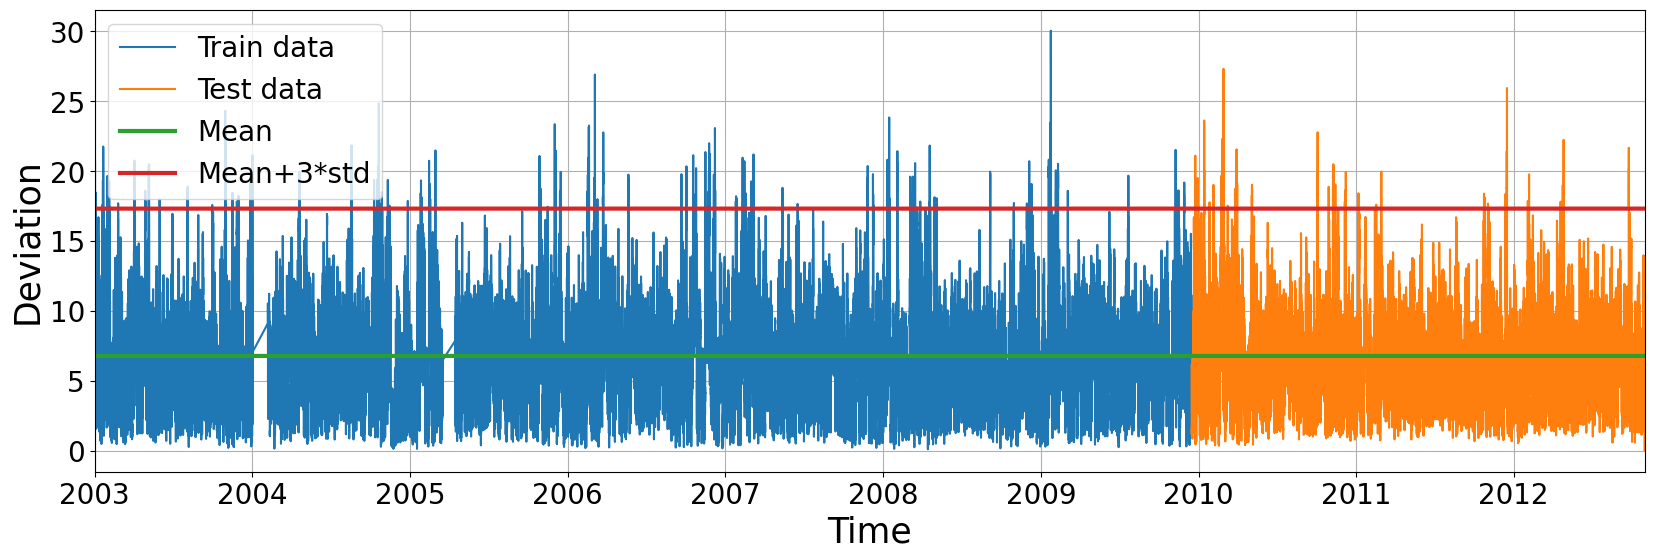

In [17]:
## Train-Test split

style.use('default')
# plt.rcParams['font.family'] = ['Computer Modern']

Cut=round(len(df)*0.7)  #70% train and 30% test

test_set=df.drop(df[0:Cut].index,axis=0)

train_set=df.drop(df[Cut:len(df)].index,axis=0)

plt.figure(figsize=(20, 6))
plt.plot(train_set.index,train_set[Y_column], label='Train data')
plt.plot(test_set.index,test_set[Y_column], label='Test data')
plt.plot(df.index,np.repeat((np.mean(train_set[Y_column])),len(df.index)),linewidth=3, label='Mean')
plt.plot(df.index,np.repeat((np.mean(train_set[Y_column])+3*np.std(train_set[Y_column])),len(df.index)),linewidth=3, label='Mean+3*std')
plt.xlim([df.index[0],df.index[len(df)-1]])
plt.legend(fontsize=20,labelcolor='black',loc=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time",fontsize=25)
plt.ylabel("Deviation",fontsize=25)
plt.grid()
# plt.savefig('./Results/Figures/Iber_target.eps',bbox_inches = 'tight', format='eps')

## Relevance

(0.0, 32.055)

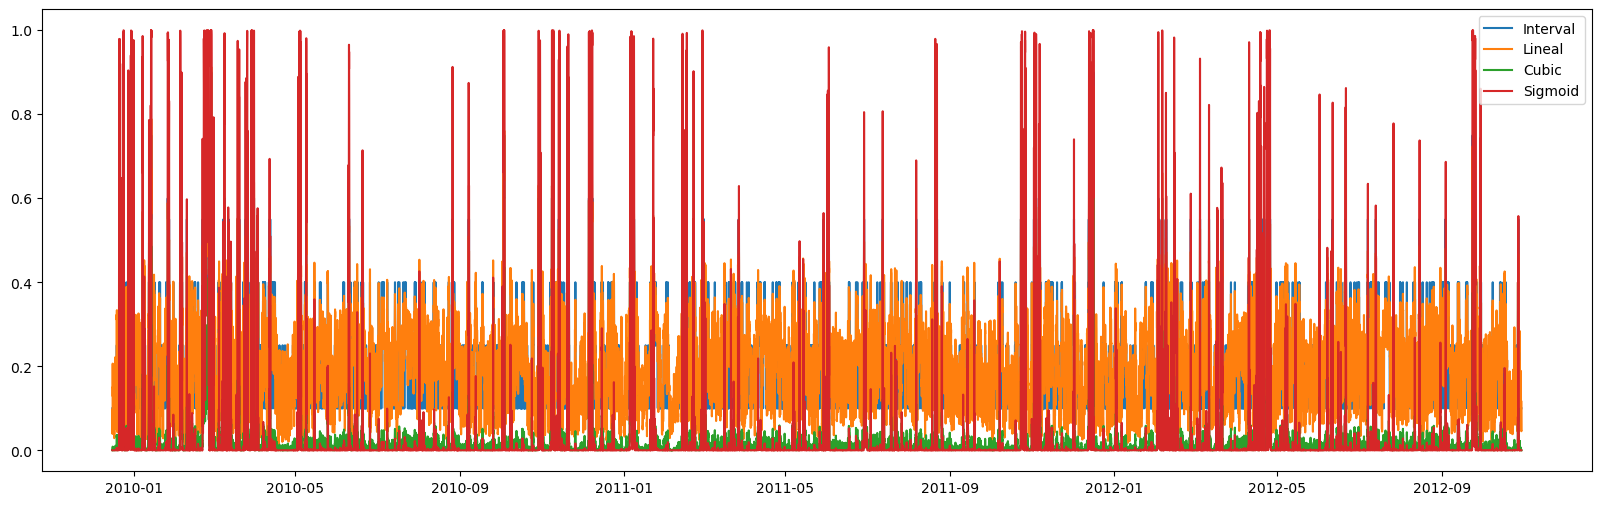

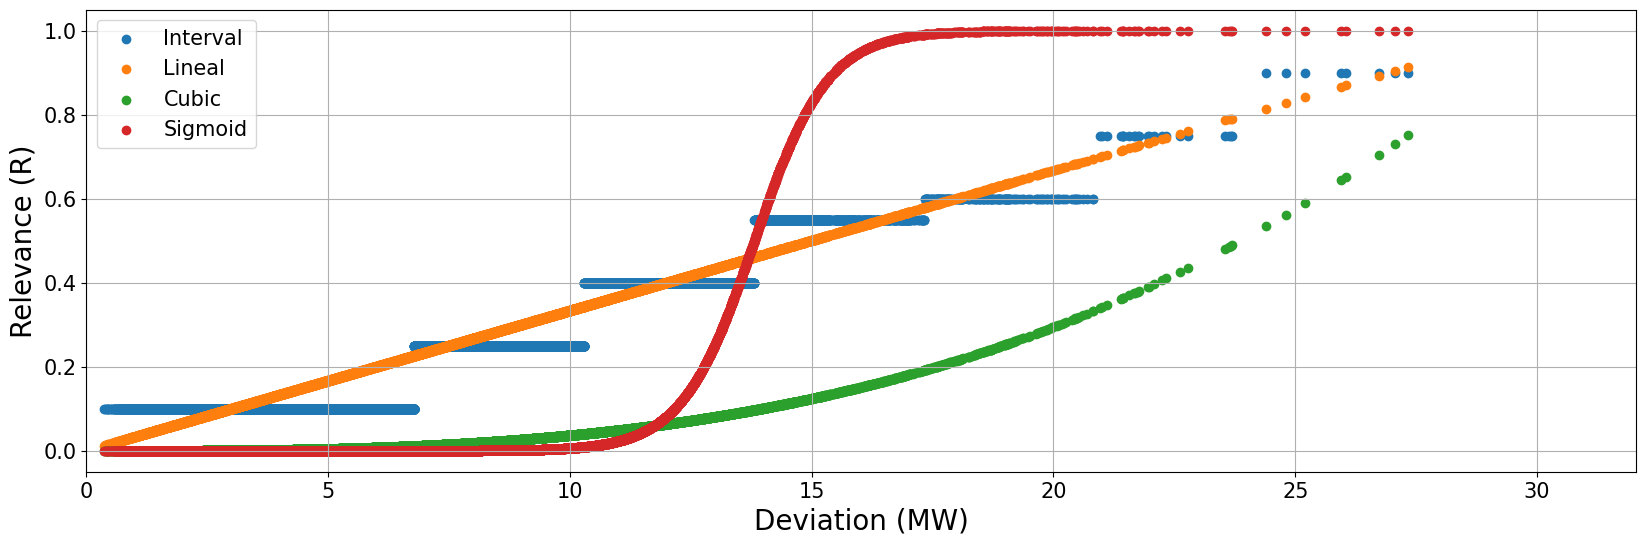

In [14]:
# Calculate Relevance Values for the Test samples

R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid=Relevance(train_set,test_set,Y_column)

plt.figure(figsize=(20, 6))
plt.plot(test_set.index,R_test_inter, label='Interval')
plt.plot(test_set.index,R_test_lineal, label='Lineal')
plt.plot(test_set.index,R_test_cubic, label='Cubic')
plt.plot(test_set.index,R_test_sigmoid, label='Sigmoid')
plt.legend()

plt.figure(figsize=(20, 6))
plt.scatter(test_set[Y_column],R_test_inter, label='Interval')
plt.scatter(test_set[Y_column],R_test_lineal, label='Lineal')
plt.scatter(test_set[Y_column],R_test_cubic, label='Cubic')
plt.scatter(test_set[Y_column],R_test_sigmoid, label='Sigmoid')
plt.legend(fontsize=15,loc=2)
plt.xlabel("Deviation (MW)",fontsize=20)
plt.ylabel("Relevance (R)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.xlim([0,max(df[Y_column])+2])

In [47]:
## Test data above mean + 3 std for outlier prediction evaluation
test_set_3std,ind=set_3std(train_set,test_set,Y_column)

# HCR (n=4)

## 1- Define Thresholds

In [48]:
import warnings
warnings.filterwarnings("ignore")

# Quartiles

Threshold0=train_set[Y_column].quantile([0.25]).values[0]
Threshold1=train_set[Y_column].quantile([0.5]).values[0]
Threshold2=train_set[Y_column].quantile([0.75]).values[0]

oversampling = False            # Variable to declare if balancing techniques are needed

# Mean + 0/1/2 std

# Threshold0=np.mean(train_set[Y_column])+0*np.std(train_set[Y_column])
# Threshold1=np.mean(train_set[Y_column])+1*np.std(train_set[Y_column])
# Threshold2=np.mean(train_set[Y_column])+2*np.std(train_set[Y_column])

# oversampling = True              # Variable to declare if balancing techniques are needed

## 2- Data labeling

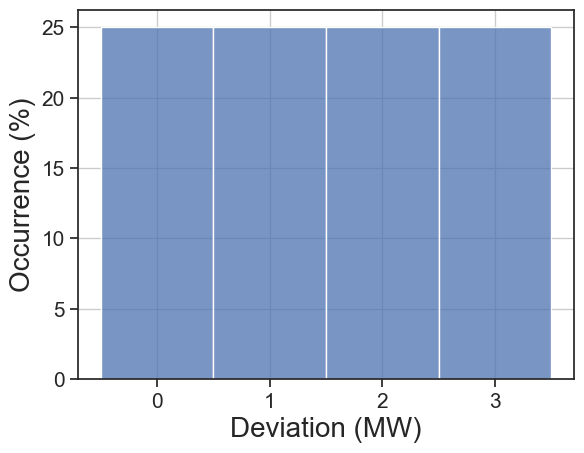

In [49]:
# Separate training data
rows=train_set.index

train_set_1=train_set[train_set[Y_column]<Threshold0]
train_set_2=train_set[(train_set[Y_column]<Threshold1) & (train_set[Y_column]>=Threshold0)]
train_set_3=train_set[(train_set[Y_column]<Threshold2) & (train_set[Y_column]>=Threshold1)]
train_set_4=train_set[train_set[Y_column]>=Threshold2]


# Assign to each sample its classification label
Outlier_train=[]
Outlier_test=[]

for i,val in enumerate(train_set[Y_column]):
    if val<=Threshold0:
        out=0
    elif Threshold0<val<=Threshold1:
        out=1
    elif Threshold1<val<=Threshold2:
        out=2        
    else:
        out=3
    Outlier_train.append(out)
for i,val in enumerate(test_set[Y_column]):
    if val<=Threshold0:
        out=0
    elif Threshold0<val<=Threshold1:
        out=1
    elif Threshold1<val<=Threshold2:
        out=2        
    else:
        out=3
    Outlier_test.append(out)

#Plot distribution of each group
sns.set(style="ticks")
ax=sns.histplot(data=train_set.drop([Y_column],axis=1).join(pd.DataFrame(Outlier_train,columns=['Outlier'],index=train_set.index)),x='Outlier',stat="percent",binwidth=0.1,discrete=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel("Deviation (MW)",fontsize=20)
ax.set_ylabel("Occurrence (%)",fontsize=20)
plt.xticks([0, 1, 2, 3])
plt.grid()
plt.show()




## 3- Balancing techniques

In [50]:
# Create List containing pool of classifiers
Clas_List=[]
Clas_Errors_List=[]
Class_iden=[]


print("No Balancing:")
clf_MLP_SMOTE0,clf_AB_SMOTE0,clf_neigh_SMOTE0,clf_RF_SMOTE0,clf_NB_SMOTE0,clf_SVC_SMOTE0,Gmean_MLP0,Gmean_AB0,Gmean_Neig0,Gmean_RF0,Gmean_NB0,Gmean_SVC0=evaluate_classifiers(train_set,test_set,train_set.drop([Y_column],axis=1),Outlier_train,Outlier_test,Y_column)
Clas_List.extend([clf_MLP_SMOTE0,clf_AB_SMOTE0,clf_neigh_SMOTE0,clf_RF_SMOTE0,clf_NB_SMOTE0,clf_SVC_SMOTE0])
Clas_Errors_List.extend([Gmean_MLP0,Gmean_AB0,Gmean_Neig0,Gmean_RF0,Gmean_NB0,Gmean_SVC0])
Class_iden.extend(["MLP_0","AB_0","Neig_0","RF_0","NB_0","SVC_0"])

if oversampling==True:
    # Oversampling techniques
    from imblearn.over_sampling import SMOTE 
    from imblearn.over_sampling import BorderlineSMOTE 
    from imblearn.over_sampling import SVMSMOTE 
    from imblearn.over_sampling import ADASYN 
    from imblearn.over_sampling import KMeansSMOTE
    X_train=train_set.drop([Y_column],axis=1)

    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("SMOTE:")
    clf_MLP_SMOTE1,clf_AB_SMOTE1,clf_neigh_SMOTE1,clf_RF_SMOTE1,clf_NB_SMOTE1,clf_SVC_SMOTE1,Gmean_MLP1,Gmean_AB1,Gmean_Neig1,Gmean_RF1,Gmean_NB1,Gmean_SVC1=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE1,clf_AB_SMOTE1,clf_neigh_SMOTE1,clf_RF_SMOTE1,clf_NB_SMOTE1,clf_SVC_SMOTE1])
    Clas_Errors_List.extend([Gmean_MLP1,Gmean_AB1,Gmean_Neig1,Gmean_RF1,Gmean_NB1,Gmean_SVC1])
    Class_iden.extend(["MLP_SMOTE","AB_SMOTE","Neig_SMOTE","RF_SMOTE","NB_SMOTE","SVC_SMOTE"])

    sm = BorderlineSMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("\nBorderlineSMOTE:")
    clf_MLP_SMOTE2,clf_AB_SMOTE2,clf_neigh_SMOTE2,clf_RF_SMOTE2,clf_NB_SMOTE2,clf_SVC_SMOTE2,Gmean_MLP2,Gmean_AB2,Gmean_Neig2,Gmean_RF2,Gmean_NB2,Gmean_SVC2=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE2,clf_AB_SMOTE2,clf_neigh_SMOTE2,clf_RF_SMOTE2,clf_NB_SMOTE2,clf_SVC_SMOTE2])
    Clas_Errors_List.extend([Gmean_MLP2,Gmean_AB2,Gmean_Neig2,Gmean_RF2,Gmean_NB2,Gmean_SVC2])
    Class_iden.extend(["MLP_BorderSMOTE","AB_BorderSMOTE","Neig_BorderSMOTE","RF_BorderSMOTE","NB_BorderSMOTE","SVC_BorderSMOTE"])

    sm = SVMSMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("\nSVMSMOTE:")
    clf_MLP_SMOTE3,clf_AB_SMOTE3,clf_neigh_SMOTE3,clf_RF_SMOTE3,clf_NB_SMOTE3,clf_SVC_SMOTE3,Gmean_MLP3,Gmean_AB3,Gmean_Neig3,Gmean_RF3,Gmean_NB3,Gmean_SVC3=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE3,clf_AB_SMOTE3,clf_neigh_SMOTE3,clf_RF_SMOTE3,clf_NB_SMOTE3,clf_SVC_SMOTE3])
    Clas_Errors_List.extend([Gmean_MLP3,Gmean_AB3,Gmean_Neig3,Gmean_RF3,Gmean_NB3,Gmean_SVC3])
    Class_iden.extend(["MLP_SVMSMOTE","AB_SVMSMOTE","Neig_SVMSMOTE","RF_SVMSMOTE","NB_SVMSMOTE","SVC_SVMSMOTE"])

    sm = ADASYN(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("\nADASYN:")
    clf_MLP_SMOTE4,clf_AB_SMOTE4,clf_neigh_SMOTE4,clf_RF_SMOTE4,clf_NB_SMOTE4,clf_SVC_SMOTE4,Gmean_MLP4,Gmean_AB4,Gmean_Neig4,Gmean_RF4,Gmean_NB4,Gmean_SVC4=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE4,clf_AB_SMOTE4,clf_neigh_SMOTE4,clf_RF_SMOTE4,clf_NB_SMOTE4,clf_SVC_SMOTE4])
    Clas_Errors_List.extend([Gmean_MLP4,Gmean_AB4,Gmean_Neig4,Gmean_RF4,Gmean_NB4,Gmean_SVC4])
    Class_iden.extend(["MLP_ADASYN","AB_ADASYN","Neig_ADASYN","RF_ADASYN","NB_ADASYN","SVC_ADASYN"])

    sm = KMeansSMOTE(random_state=42,cluster_balance_threshold=0.02)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("\nKMeansSMOTE:")
    clf_MLP_SMOTE5,clf_AB_SMOTE5,clf_neigh_SMOTE5,clf_RF_SMOTE5,clf_NB_SMOTE5,clf_SVC_SMOTE5,Gmean_MLP5,Gmean_AB5,Gmean_Neig5,Gmean_RF5,Gmean_NB5,Gmean_SVC5=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE5,clf_AB_SMOTE5,clf_neigh_SMOTE5,clf_RF_SMOTE5,clf_NB_SMOTE5,clf_SVC_SMOTE5])
    Clas_Errors_List.extend([Gmean_MLP5,Gmean_AB5,Gmean_Neig5,Gmean_RF5,Gmean_NB5,Gmean_SVC5])
    Class_iden.extend(["MLP_KMSMOTE","AB_KMSMOTE","Neig_KMSMOTE","RF_KMSMOTE","NB_KMSMOTE","SVC_KMSMOTE"])

    # Undersampling

    # Calculate percentage of mayority class to removed
    Min_set=min(train_set_1.shape[0],train_set_2.shape[0],train_set_3.shape[0],train_set_4.shape[0])
    Max_set=max(train_set_1.shape[0],train_set_2.shape[0],train_set_3.shape[0],train_set_4.shape[0])
    Removed_percentage=((Max_set-Min_set)/2)/Max_set

    rows=train_set.index
    # Create a copy of the train set    
    train_set_m2=train_set

    # Removed data
    for row in range (len(rows)-1,0,-1):
        if train_set[Y_column][i]<=Threshold0:
            rand=np.random.random(1)
            if rand < Removed_percentage:
                train_set_m2=train_set_m2.drop(index=train_set_m2.index[row])

    # Assign labels to new training data
    Outlier_train=[]

    for i,var in enumerate(len(train_set_m2[Y_column])):
        if var<=Threshold0:
            out=0
        elif Threshold0<var<=Threshold1:
            out=1
        elif Threshold1<var<=Threshold2:
            out=2        
        else:
            out=3
        Outlier_train.append(out)



    # Evaluate classifiers
    print("Undersampling")
    clf_MLP_under,clf_AB_under,clf_neigh_under,clf_RF_under,clf_NB_under,clf_SVC_under,Gmean_MLP_under,Gmean_AB_under,Gmean_Neig_under,Gmean_RF_under,Gmean_NB_under,Gmean_SVC_under=evaluate_classifiers(train_set_m2,test_set,train_set_m2.drop([Y_column],axis=1),Outlier_train,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_under,clf_AB_under,clf_neigh_under,clf_RF_under,clf_NB_under,clf_SVC_under])
    Clas_Errors_List.extend([Gmean_MLP_under,Gmean_AB_under,Gmean_Neig_under,Gmean_RF_under,Gmean_NB_under,Gmean_SVC_under])
    Class_iden.extend(["MLP_under","AB_under","Neig_under","RF_under","NB_under","SVC_under"])

No Balancing:
SVC:
0.6392500451997924
Random Forest:
0.6488064038098583
Naive Bayes:
0.49549664773314084
KNeighbors:
0.5800786047102823
AdaBoost:
0.5944814786237386
MLP:
0.5919456472079467
SMOTE:
SVC:
0.6393459822129657
Random Forest:
0.648040434242447
Naive Bayes:
0.49549664773314084
KNeighbors:
0.5799535541943498
AdaBoost:
0.5945371770093565
MLP:
0.5699729807473615

BorderlineSMOTE:
SVC:
0.6391934412123556
Random Forest:
0.6479876885776414
Naive Bayes:
0.4955627040337401
KNeighbors:
0.580276684642987
AdaBoost:
0.5919217488511459
MLP:
0.608535648605305


## 4- Voting Classifier

In [ ]:
print('Voting classifier')
# Calculate the prediction of each classifier for each test sample and compute a voting classifier to return the final solution
from sklearn import metrics
from imblearn.metrics import geometric_mean_score

_,_,X_test,Y_test=divide_variables(train_set,test_set,Y_column,scale=scale)

pred=[]
for clf in Clas_List:    
    pred.append(clf.predict(X_test.values))
pre=[]
for i,value in range(0,len(pred[0])):
    predict0=0
    predict1=0
    predict2=0
    predict3=0
    for j in range(0,len(pred)):    
        if pred[j][i]==0:
            predict0+=1
        elif pred[j][i]==1:
            predict1+=1 
        elif pred[j][i]==2:
            predict2+=1 
        elif pred[j][i]==3:
            predict3+=1             
    pre.append(0 if predict0==max(predict0,predict1,predict2,predict3) else 1 if predict1==max(predict0,predict1,predict2,predict3)else 2 if predict2==max(predict0,predict1,predict2,predict3)else 3 )

    # print(predict0,predict1,predict2,predict3,pre[i],Outlier_test[i])
Gmean_SVC=geometric_mean_score(np.array(Outlier_test), np.array(pre).reshape(-1,1))
print(Gmean_SVC)

## 5- Evaluate regression models

In [ ]:
# Create 4 ML regression models for each method and train with the 4 training data groups. 
# Then use the corresponding model according to the voting classifier value for each test sample
X_train_1,Y_train_1,_,_=divide_variables(train_set_1,test_set,Y_column,scale=scale)
X_train_2,Y_train_2,_,_=divide_variables(train_set_2,test_set,Y_column,scale=scale)
X_train_3,Y_train_3,_,_=divide_variables(train_set_3,test_set,Y_column,scale=scale)
X_train_4,Y_train_4,_,_=divide_variables(train_set_4,test_set,Y_column,scale=scale)
_,_,X_test,Y_test=divide_variables(train_set,test_set,Y_column,scale=scale)
_,_,X_test_3std,Y_test_3std=divide_variables(train_set,test_set_3std,Y_column,scale=1)
from sklearn.metrics import mean_absolute_error


Linear Reg:

MAE=122.34
MAE_3std=669.1
MAE_Pondered_Mean=601.010009765625
Recall=0.27
False Positive Rate=0.01
G-mean=0.52



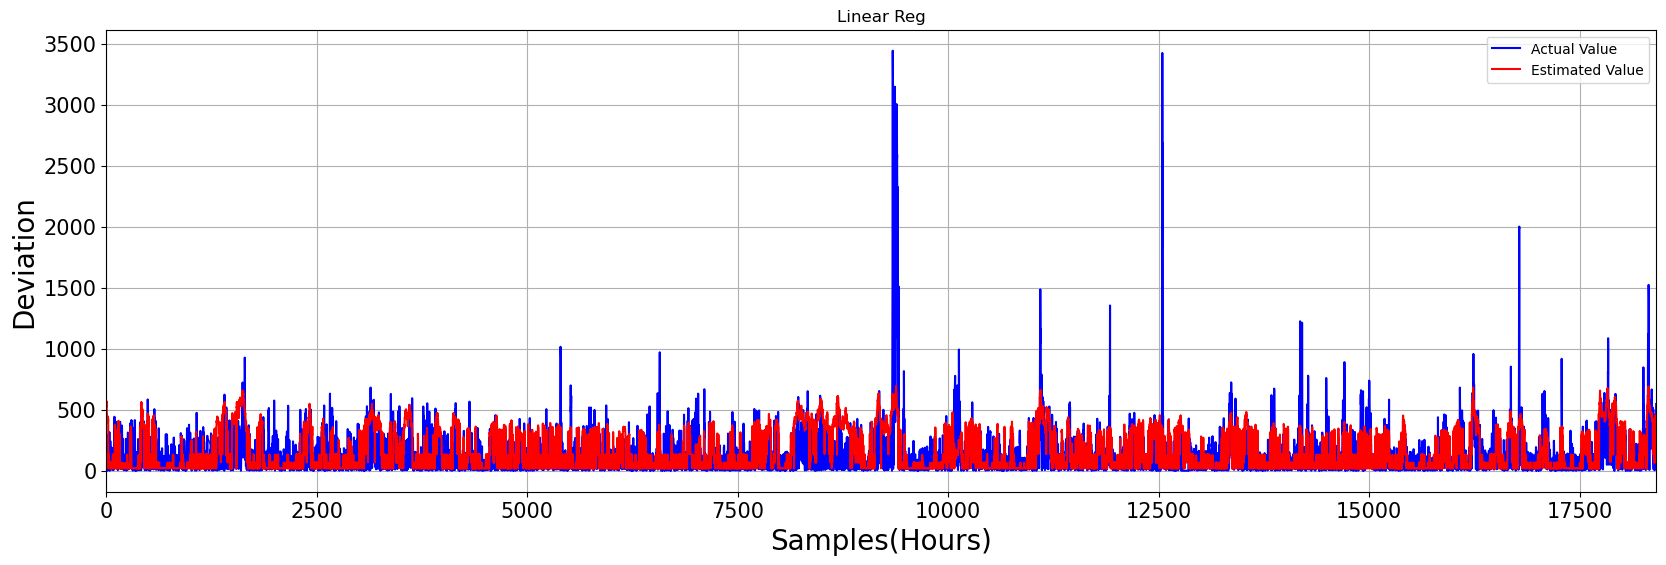

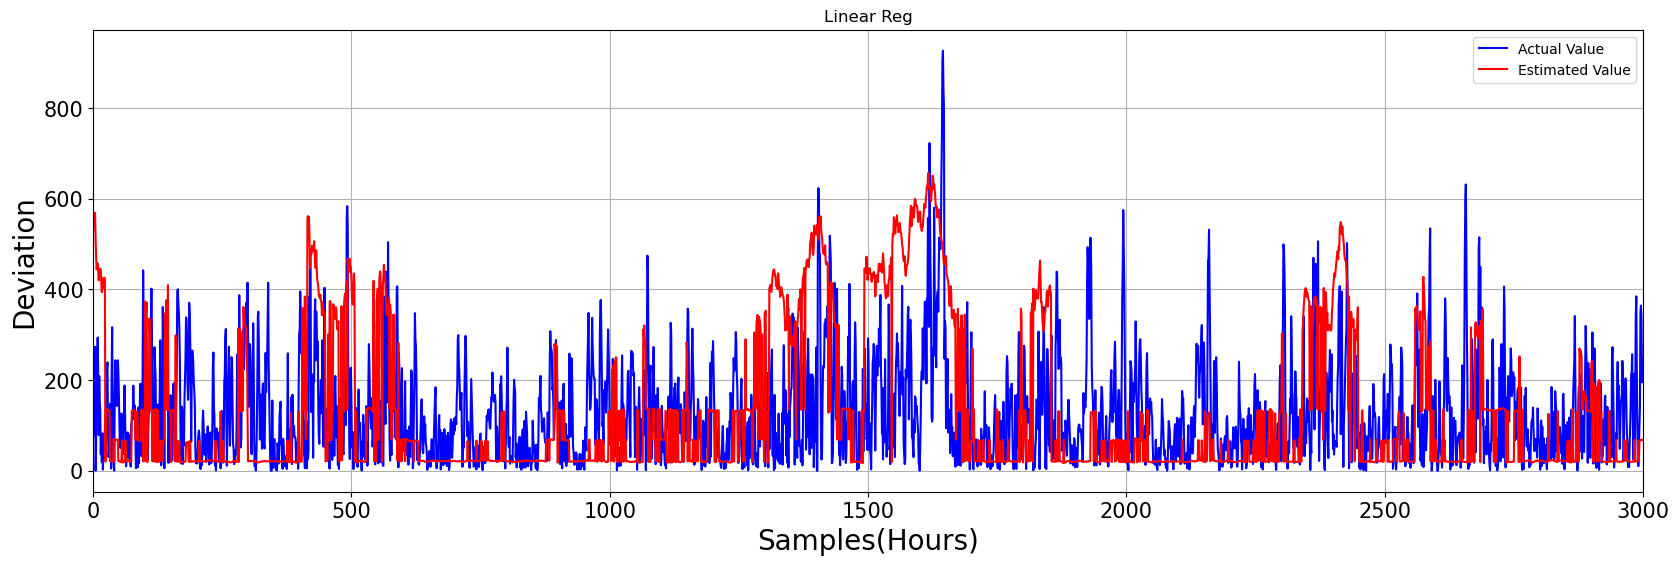

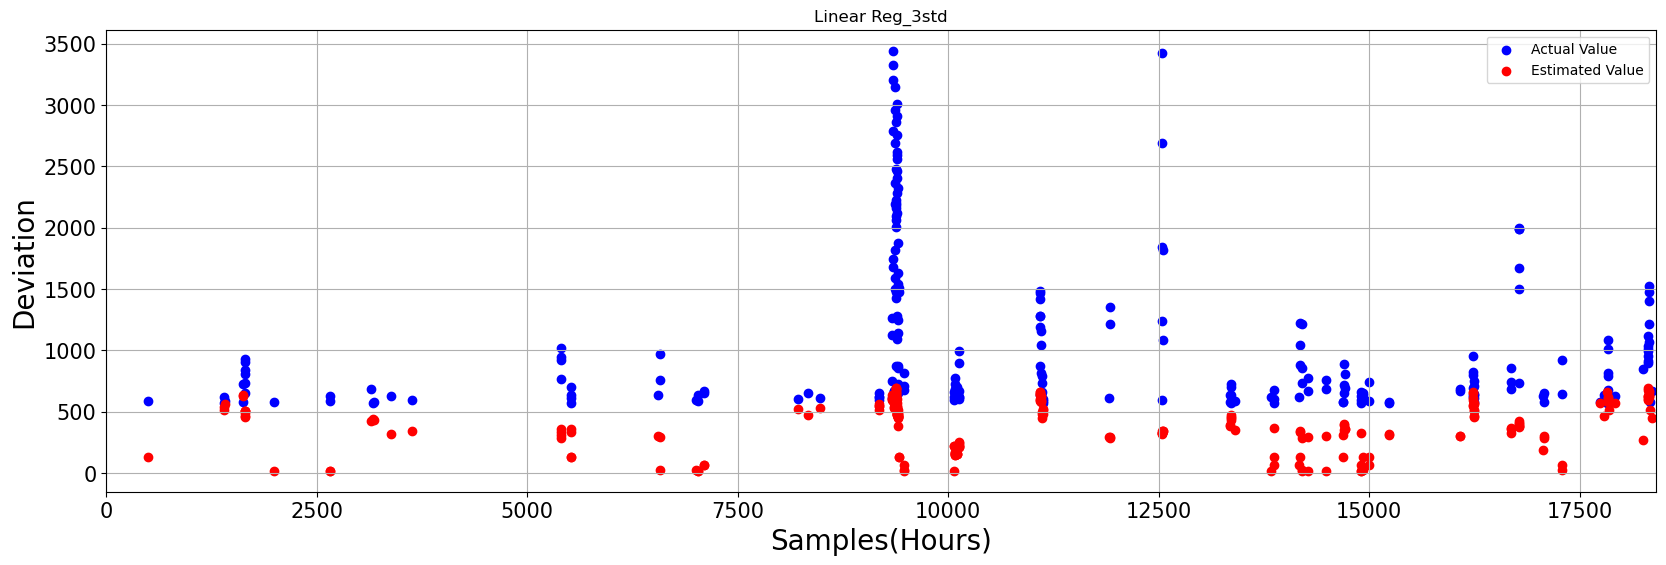

In [ ]:
#Linear Reg
from sklearn.linear_model import LinearRegression
lm_1=LinearRegression()
lm_2=LinearRegression()
lm_3=LinearRegression()
lm_4=LinearRegression()
lm_1.fit(X_train_1,Y_train_1)
lm_2.fit(X_train_2,Y_train_2)
lm_3.fit(X_train_3,Y_train_3)
lm_4.fit(X_train_4,Y_train_4)
Y_pred=[]
for i in range(0,len(Y_test)):
    if pre[i]==0:
        y_pr=lm_1.predict(X_test.iloc[[i]])
    elif pre[i]==1:
        y_pr=lm_2.predict(X_test.iloc[[i]])
    elif pre[i]==2:
        y_pr=lm_3.predict(X_test.iloc[[i]])
    elif pre[i]==3:
        y_pr=lm_4.predict(X_test.iloc[[i]])
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)
Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
    if pre[ind[i]]==0:
        y_pr=lm_1.predict(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==1:
        y_pr=lm_2.predict(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==2:
        y_pr=lm_3.predict(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==3:
        y_pr=lm_4.predict(X_test_3std.iloc[[i]])
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nLinear Reg:')
mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "Linear Reg")

In [ ]:
#Reg Tree
from sklearn.tree import DecisionTreeRegressor

lm_1=DecisionTreeRegressor(max_depth=400)
lm_2=DecisionTreeRegressor(max_depth=400)
lm_3=DecisionTreeRegressor(max_depth=400)
lm_4=DecisionTreeRegressor(max_depth=400)
lm_1.fit(X_train_1,Y_train_1)
lm_2.fit(X_train_2,Y_train_2)
lm_3.fit(X_train_3,Y_train_3)
lm_4.fit(X_train_4,Y_train_4)
Y_pred=[]
for i in range(0,len(Y_test)):
    # Out_pred=clf.predict(X_test.iloc[[i]])
    if pre[i]==0:
        y_pr=lm_1.predict(X_test.iloc[[i]])
    elif pre[i]==1:
        y_pr=lm_2.predict(X_test.iloc[[i]])
    elif pre[i]==2:
        y_pr=lm_3.predict(X_test.iloc[[i]])
    elif pre[i]==3:
        y_pr=lm_4.predict(X_test.iloc[[i]])
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)
Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
    # Out_pred=clf.predict(X_test_3std.iloc[[i]])
    if pre[ind[i]]==0:
        y_pr=lm_1.predict(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==1:
        y_pr=lm_2.predict(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==2:
        y_pr=lm_3.predict(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==3:
        y_pr=lm_4.predict(X_test_3std.iloc[[i]])
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nRegression Trees:')
mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "Regression Trees")

In [ ]:
#RF
from sklearn.ensemble import RandomForestRegressor
lm_1=RandomForestRegressor(n_estimators=400)
lm_2=RandomForestRegressor(n_estimators=400)
lm_3=RandomForestRegressor(n_estimators=400)
lm_4=RandomForestRegressor(n_estimators=400)
lm_1.fit(X_train_1,Y_train_1)
lm_2.fit(X_train_2,Y_train_2)
lm_3.fit(X_train_3,Y_train_3)
lm_4.fit(X_train_4,Y_train_4)
Y_pred=[]
for i in range(0,len(Y_test)):
    
    if pre[i]==0:
        y_pr=lm_1.predict(X_test.iloc[[i]])
    elif pre[i]==1:
        y_pr=lm_2.predict(X_test.iloc[[i]])
    elif pre[i]==2:
        y_pr=lm_3.predict(X_test.iloc[[i]])
    elif pre[i]==3:
        y_pr=lm_4.predict(X_test.iloc[[i]])
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)
Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
   
    if pre[ind[i]]==0:
        y_pr=lm_1.predict(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==1:
        y_pr=lm_2.predict(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==2:
        y_pr=lm_3.predict(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==3:
        y_pr=lm_4.predict(X_test_3std.iloc[[i]])
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nRandom Forest:')
mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "Random Forest")



In [ ]:
#MLP

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

normalizer_1 = tf.keras.layers.Normalization(axis=-1)
normalizer_2 = tf.keras.layers.Normalization(axis=-1)
normalizer_3 = tf.keras.layers.Normalization(axis=-1)
normalizer_4 = tf.keras.layers.Normalization(axis=-1)
normalizer_1.adapt(np.array(X_train_1))
normalizer_2.adapt(np.array(X_train_2))
normalizer_3.adapt(np.array(X_train_3))
normalizer_4.adapt(np.array(X_train_4))

def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                    optimizer=tf.keras.optimizers.Adam(0.001))
    return model

lm_1 = build_and_compile_model(normalizer_1)
lm_2 = build_and_compile_model(normalizer_2)
lm_3 = build_and_compile_model(normalizer_3)
lm_4 = build_and_compile_model(normalizer_4)
# dnn_model.summary()

#%%time
history = lm_1.fit(
    X_train_1,
    Y_train_1,
    validation_split=0.2,
    verbose=0, epochs=100)
history = lm_2.fit(
    X_train_2,
    Y_train_2,
    validation_split=0.2,
    verbose=0, epochs=100)
history = lm_3.fit(
    X_train_3,
    Y_train_3,
    validation_split=0.2,
    verbose=0, epochs=100)
history = lm_4.fit(
    X_train_4,
    Y_train_4,
    validation_split=0.2,
    verbose=0, epochs=100)
    
lm_1.fit(X_train_1,Y_train_1)
lm_2.fit(X_train_2,Y_train_2)
lm_3.fit(X_train_3,Y_train_3)
lm_4.fit(X_train_4,Y_train_4)
Y_pred=[]
for i in range(0,len(Y_test)):
    if pre[i]==0:
        y_pr=lm_1.predict(X_test.iloc[[i]])[0][0]
    elif pre[i]==1:
        y_pr=lm_2.predict(X_test.iloc[[i]])[0][0]
    elif pre[i]==2:
        y_pr=lm_3.predict(X_test.iloc[[i]])[0][0]
    elif pre[i]==3:
        y_pr=lm_4.predict(X_test.iloc[[i]])[0][0]
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)
Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
    if pre[ind[i]]==0:
        y_pr=lm_1.predict(X_test_3std.iloc[[i]])[0][0]
    elif pre[ind[i]]==1:
        y_pr=lm_2.predict(X_test_3std.iloc[[i]])[0][0]
    elif pre[ind[i]]==2:
        y_pr=lm_3.predict(X_test_3std.iloc[[i]])[0][0]
    elif pre[ind[i]]==3:
        y_pr=lm_4.predict(X_test_3std.iloc[[i]])[0][0]
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nMLP:')
mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "MLP")



In [ ]:
#ELM
from scipy.linalg import pinv

input_size = len(X_train_1.columns)
hidden_size = 500
input_weights = np.random.normal(size=[input_size,hidden_size])
biases = np.random.normal(size=[hidden_size])
def relu(x):
    return np.maximum(x, 0, x)

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

output_weights_1 = np.dot(pinv(hidden_nodes(X_train_1)), Y_train_1)
output_weights_2 = np.dot(pinv(hidden_nodes(X_train_2)), Y_train_2)
output_weights_3 = np.dot(pinv(hidden_nodes(X_train_3)), Y_train_3)
output_weights_4 = np.dot(pinv(hidden_nodes(X_train_4)), Y_train_4)



def predictELM_1(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights_1)
    return out

def predictELM_2(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights_2)
    return out

def predictELM_3(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights_3)
    return out

def predictELM_4(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights_4)
    return out

Y_pred=[]
for i in range(0,len(Y_test)):
   
    if pre[i]==0:
        y_pr=predictELM_1(X_test.iloc[[i]])
    elif pre[i]==1:
        y_pr=predictELM_2(X_test.iloc[[i]])
    elif pre[i]==2:
        y_pr=predictELM_3(X_test.iloc[[i]])
    elif pre[i]==3:
        y_pr=predictELM_4(X_test.iloc[[i]])
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)
Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
    
    if pre[ind[i]]==0:
        y_pr=predictELM_1(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==1:
        y_pr=predictELM_2(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==2:
        y_pr=predictELM_3(X_test_3std.iloc[[i]])
    elif pre[ind[i]]==3:
        y_pr=predictELM_4(X_test_3std.iloc[[i]])
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nELM:')
mae,mae_3std,mae_pondered_mean,false_pos_rate,rec,gm=errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
print('\nMAE={}\nMAE_3std={}\nMAE_Pondered_Mean={}\nRecall={}\nFalse Positive Rate={}\nG-mean={}\n'.format(np.round(mae,2),np.round(mae_3std,2),np.round(mae_pondered_mean,2),np.round(rec,2),np.round(false_pos_rate,2),np.round(gm,2)))     
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "ELM")


# HCR (n=2)

## 1- Define Thresholds

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Threshold_std = 0    # 1 / 2 / 3

Threshold=np.mean(train_set[Y_column])+Threshold_std*np.std(train_set[Y_column])

## 2- Data labeling

(15717, 71) (42958, 71) (27241, 71)
0.3658689883141673
0.3362846279196089


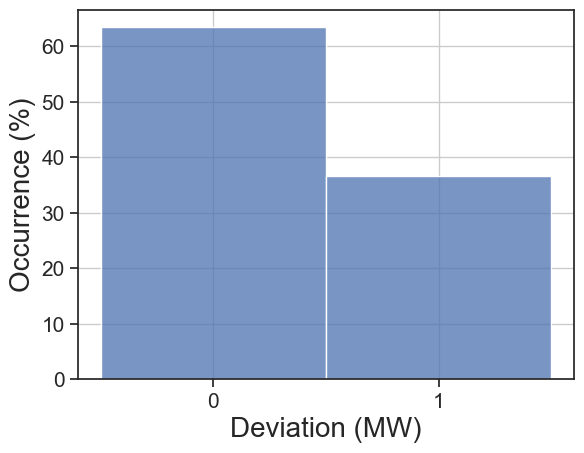

In [ ]:
# Separate training data

train_set_onlyoutlier=train_set[train_set[Y_column]>Threshold]
train_set_nooutlier=train_set[train_set[Y_column]<=Threshold]

print(train_set_onlyoutlier.shape,train_set.shape,train_set_nooutlier.shape)


# Assign to each sample its classification label

Outlier_train=[]
Outlier_test=[]
for i in range(0,len(train_set[Y_column])):
    if train_set[Y_column][i]<=Threshold:
        out=0
    else:
        out=1
    Outlier_train.append(out)
for i in range(0,len(test_set[Y_column])):
    if test_set[Y_column][i]<=Threshold:
        out=0
    else:
        out=1
    Outlier_test.append(out)
print(np.count_nonzero(Outlier_train)/len(Outlier_train))
print(np.count_nonzero(Outlier_test)/len(Outlier_test))


#Plot distribution of each group
sns.set(style="ticks")
ax=sns.histplot(data=train_set.drop([Y_column],axis=1).join(pd.DataFrame(Outlier_train,columns=['Outlier'],index=train_set.index)),x='Outlier',stat="percent",binwidth=0.1,discrete=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel("Deviation (MW)",fontsize=20)
ax.set_ylabel("Occurrence (%)",fontsize=20)
plt.xticks([0, 1])
plt.grid()
plt.show()

## 3- Balancing techniques

In [ ]:
print("No Balancing:")
clf_MLP_SMOTE0,clf_AB_SMOTE0,clf_neigh_SMOTE0,clf_RF_SMOTE0,clf_NB_SMOTE0,clf_SVC_SMOTE0,Gmean_MLP0,Gmean_AB0,Gmean_Neig0,Gmean_RF0,Gmean_NB0,Gmean_SVC0=evaluate_classifiers(train_set,test_set,train_set.drop([Y_column],axis=1),Outlier_train,Outlier_test,Y_column)
Clas_List.extend([clf_MLP_SMOTE0,clf_AB_SMOTE0,clf_neigh_SMOTE0,clf_RF_SMOTE0,clf_NB_SMOTE0,clf_SVC_SMOTE0])
Clas_Errors_List.extend([Gmean_MLP0,Gmean_AB0,Gmean_Neig0,Gmean_RF0,Gmean_NB0,Gmean_SVC0])
Class_iden.extend(["MLP_0","AB_0","Neig_0","RF_0","NB_0","SVC_0"])

In [ ]:
if np.count_nonzero(Outlier_train)/len(Outlier_train)<0.3:   # Only perform balancing techniques where the minority cluss represent under 30% of the total training data

    ## Oversampling classifiers

    from imblearn.over_sampling import SMOTE 
    from imblearn.over_sampling import BorderlineSMOTE 
    from imblearn.over_sampling import SVMSMOTE 
    from imblearn.over_sampling import ADASYN 
    from imblearn.over_sampling import KMeansSMOTE
    X_train=train_set.drop([Y_column],axis=1)
    
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("SMOTE:")
    clf_MLP_SMOTE1,clf_AB_SMOTE1,clf_neigh_SMOTE1,clf_RF_SMOTE1,clf_NB_SMOTE1,clf_SVC_SMOTE1,Gmean_MLP1,Gmean_AB1,Gmean_Neig1,Gmean_RF1,Gmean_NB1,Gmean_SVC1=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE1,clf_AB_SMOTE1,clf_neigh_SMOTE1,clf_RF_SMOTE1,clf_NB_SMOTE1,clf_SVC_SMOTE1])
    Clas_Errors_List.extend([Gmean_MLP1,Gmean_AB1,Gmean_Neig1,Gmean_RF1,Gmean_NB1,Gmean_SVC1])
    Class_iden.extend(["MLP_SMOTE","AB_SMOTE","Neig_SMOTE","RF_SMOTE","NB_SMOTE","SVC_SMOTE"])
    # # plt.figure()
    # sns.set(style="ticks")
    # ax=sns.histplot(data=X_res.join(y_res), x=Y_column, kde=True, bins=50)
    # ax.set(xlabel='Wind Speed (m/s)', ylabel='Count')
    # plt.grid()
    # plt.savefig('./Figures/Pena_hist_SMOTE'+Threshold_std+'.eps', format='eps')
    # plt.show()

    sm = BorderlineSMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("\nBorderlineSMOTE:")
    clf_MLP_SMOTE2,clf_AB_SMOTE2,clf_neigh_SMOTE2,clf_RF_SMOTE2,clf_NB_SMOTE2,clf_SVC_SMOTE2,Gmean_MLP2,Gmean_AB2,Gmean_Neig2,Gmean_RF2,Gmean_NB2,Gmean_SVC2=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE2,clf_AB_SMOTE2,clf_neigh_SMOTE2,clf_RF_SMOTE2,clf_NB_SMOTE2,clf_SVC_SMOTE2])
    Clas_Errors_List.extend([Gmean_MLP2,Gmean_AB2,Gmean_Neig2,Gmean_RF2,Gmean_NB2,Gmean_SVC2])
    Class_iden.extend(["MLP_BorderSMOTE","AB_BorderSMOTE","Neig_BorderSMOTE","RF_BorderSMOTE","NB_BorderSMOTE","SVC_BorderSMOTE"])

    # sns.set(style="ticks")
    # ax=sns.histplot(data=X_res.join(y_res), x=Y_column, kde=True, bins=50)
    # ax.set(xlabel='Wind Speed (m/s)', ylabel='Count')
    # plt.grid()
    # plt.savefig('./Figures/Pena_hist_BorderlineSMOTE'+Threshold_std+'.eps', format='eps')
    # plt.show()

    sm = SVMSMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("\nSVMSMOTE:")
    clf_MLP_SMOTE3,clf_AB_SMOTE3,clf_neigh_SMOTE3,clf_RF_SMOTE3,clf_NB_SMOTE3,clf_SVC_SMOTE3,Gmean_MLP3,Gmean_AB3,Gmean_Neig3,Gmean_RF3,Gmean_NB3,Gmean_SVC3=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE3,clf_AB_SMOTE3,clf_neigh_SMOTE3,clf_RF_SMOTE3,clf_NB_SMOTE3,clf_SVC_SMOTE3])
    Clas_Errors_List.extend([Gmean_MLP3,Gmean_AB3,Gmean_Neig3,Gmean_RF3,Gmean_NB3,Gmean_SVC3])
    Class_iden.extend(["MLP_SVMSMOTE","AB_SVMSMOTE","Neig_SVMSMOTE","RF_SVMSMOTE","NB_SVMSMOTE","SVC_SVMSMOTE"])

    # sns.set(style="ticks")
    # ax=sns.histplot(data=X_res.join(y_res), x=Y_column, kde=True, bins=50)
    # ax.set(xlabel='Wind Speed (m/s)', ylabel='Count')
    # plt.grid()
    # plt.savefig('./Figures/Pena_hist_SVMSMOTE'+Threshold_std+'.eps', format='eps')
    # plt.show()

    sm = ADASYN(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("\nADASYN:")
    clf_MLP_SMOTE4,clf_AB_SMOTE4,clf_neigh_SMOTE4,clf_RF_SMOTE4,clf_NB_SMOTE4,clf_SVC_SMOTE4,Gmean_MLP4,Gmean_AB4,Gmean_Neig4,Gmean_RF4,Gmean_NB4,Gmean_SVC4=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE4,clf_AB_SMOTE4,clf_neigh_SMOTE4,clf_RF_SMOTE4,clf_NB_SMOTE4,clf_SVC_SMOTE4])
    Clas_Errors_List.extend([Gmean_MLP4,Gmean_AB4,Gmean_Neig4,Gmean_RF4,Gmean_NB4,Gmean_SVC4])
    Class_iden.extend(["MLP_ADASYN","AB_ADASYN","Neig_ADASYN","RF_ADASYN","NB_ADASYN","SVC_ADASYN"])

    # sns.set(style="ticks")
    # ax=sns.histplot(data=X_res.join(y_res), x=Y_column, kde=True, bins=50)
    # ax.set(xlabel='Wind Speed (m/s)', ylabel='Count')
    # plt.grid()
    # plt.savefig('./Figures/Pena_hist_Adasyn'+Threshold_std+'.eps', format='eps')
    # plt.show()

    sm = KMeansSMOTE(random_state=42,cluster_balance_threshold=0.02)
    X_res, y_res = sm.fit_resample(X_train, Outlier_train)
    print("\nKMeansSMOTE:")
    clf_MLP_SMOTE5,clf_AB_SMOTE5,clf_neigh_SMOTE5,clf_RF_SMOTE5,clf_NB_SMOTE5,clf_SVC_SMOTE5,Gmean_MLP5,Gmean_AB5,Gmean_Neig5,Gmean_RF5,Gmean_NB5,Gmean_SVC5=evaluate_classifiers(train_set,test_set,X_res,y_res,Outlier_test,Y_column)
    Clas_List.extend([clf_MLP_SMOTE5,clf_AB_SMOTE5,clf_neigh_SMOTE5,clf_RF_SMOTE5,clf_NB_SMOTE5,clf_SVC_SMOTE5])
    Clas_Errors_List.extend([Gmean_MLP5,Gmean_AB5,Gmean_Neig5,Gmean_RF5,Gmean_NB5,Gmean_SVC5])
    Class_iden.extend(["MLP_KMSMOTE","AB_KMSMOTE","Neig_KMSMOTE","RF_KMSMOTE","NB_KMSMOTE","SVC_KMSMOTE"])

    # sns.set(style="ticks")
    # ax=sns.histplot(data=X_res.join(y_res), x=Y_column, kde=True, bins=50)
    # ax.set(xlabel='Wind Speed (m/s)', ylabel='Count')
    # plt.grid()
    # plt.savefig('./Figures/Pena_hist_KmeanSMOTE'+Threshold_std+'.eps', format='eps')
    # plt.show()

    ## Undersampling classifiers
    Outlier_train=[]
    Outlier_test=[]
    for i in range(0,len(train_set[Y_column])):
        if train_set[Y_column][i]<=Threshold:
            out=0
        else:
            out=1
        Outlier_train.append(out)
    for i in range(0,len(test_set[Y_column])):
        if test_set[Y_column][i]<=Threshold:
            out=0
        else:
            out=1
        Outlier_test.append(out)
    x_50=(1-(np.count_nonzero(Outlier_train)/len(Outlier_train))/0.5)/(1-(np.count_nonzero(Outlier_train)/len(Outlier_train)))   # % Of removed points to balance train data to 50%
    j=x_50
    rows=train_set.index
    
    train_set_m2=train_set

    for row in range (len(rows)-1,0,-1):
        if train_set[Y_column][row]<Threshold:
            rand=np.random.random(1)
            if rand < j:
                train_set_m2=train_set_m2.drop(index=train_set_m2.index[row])

    Outlier_train=[]
    Outlier_test=[]
    for i in range(0,len(train_set_m2[Y_column])):
        if train_set_m2[Y_column][i]<=Threshold:
            out=[0]
        else:
            out=[1]
        Outlier_train.append(out)
    for i in range(0,len(test_set[Y_column])):
        if test_set[Y_column][i]<=Threshold:
            out=[0]
        else:
            out=[1]
        Outlier_test.append(out)
    # print(np.count_nonzero(Outlier_train)/len(Outlier_train))
    # print(np.count_nonzero(Outlier_test)/len(Outlier_test))

    X_train=train_set_m2.drop([Y_column],axis=1)

    # sns.set(style="ticks")
    # ax=sns.histplot(data=X_train.join(Outlier_train), x=Y_column, kde=True, bins=50)
    # ax.set(xlabel='Wind Speed (m/s)', ylabel='Count')
    # plt.grid()
    # plt.savefig('./Figures/Pena_hist_Under'+Threshold_std+'.eps', format='eps')
    # plt.show()

    print("\n{}:".format(j))
    clf_MLP_under,clf_AB_under,clf_neigh_under,clf_RF_under,clf_NB_under,clf_SVC_under,Gmean_MLP_under,Gmean_AB_under,Gmean_Neig_under,Gmean_RF_under,Gmean_NB_under,Gmean_SVC_under=evaluate_classifiers(train_set,test_set,X_train,np.array(Outlier_train).ravel(),Outlier_test,Y_column)
    globals()['clf_MLP_under%s' % j]=clf_MLP_under
    globals()['clf_AB_under%s' % j]=clf_AB_under
    globals()['clf_neigh_under%s' % j]=clf_neigh_under
    globals()['clf_RF_under%s' % j]=clf_RF_under
    globals()['clf_NB_under%s' % j]=clf_NB_under
    globals()['clf_SVC_under%s' % j]=clf_SVC_under

    globals()['Gmean_MLP_under%s' % j]=Gmean_MLP_under
    globals()['Gmean_AB_under%s' % j]=Gmean_AB_under
    globals()['Gmean_neigh_under%s' % j]=Gmean_Neig_under
    globals()['Gmean_RF_under%s' % j]=Gmean_RF_under
    globals()['Gmean_NB_under%s' % j]=Gmean_NB_under
    globals()['Gmean_SVC_under%s' % j]=Gmean_SVC_under
    Clas_List.extend([globals()['clf_MLP_under%s' % j],globals()['clf_AB_under%s' % j],globals()['clf_neigh_under%s' % j],globals()['clf_RF_under%s' % j],globals()['clf_NB_under%s' % j],globals()['clf_SVC_under%s' % j]])
    Clas_Errors_List.extend([globals()['Gmean_MLP_under%s' % j],globals()['Gmean_AB_under%s' % j],globals()['Gmean_neigh_under%s' % j],globals()['Gmean_RF_under%s' % j],globals()['Gmean_NB_under%s' % j],globals()['Gmean_SVC_under%s' % j]])
    Class_iden.extend(['MLP_under%s' % j,'AB_under%s' % j,'Neig_under%s' % j,'RF_under%s' % j,'NB_under%s' % j,'SVC_under%s' % j])



## 4- Voting Classifier

In [ ]:
print('Voting regressor')
from sklearn import metrics
from imblearn.metrics import geometric_mean_score


pred=[]
for clf in Clas_List:    
    pred.append(clf.predict(X_test))
pre=[]
for i in range(0,len(pred[0])):
    predict0=0
    predict1=0
    for j in range(0,len(pred)):    
        if pred[j][i]==0:
            predict0+=1
        else:
            predict1+=1 
    pre.append(0 if predict0>predict1 else 1)

    print(predict0,predict1,Outlier_test[i])
Gmean_SVC=geometric_mean_score(np.array(Outlier_test), np.array(pre).reshape(-1,1))
print(Gmean_SVC)


## 5- Evaluate regression models

In [ ]:
from sklearn.metrics import mean_absolute_error

X_train_noout,Y_train_noout,_,_=divide_variables(train_set_nooutlier,test_set,Y_column,scale=scale)
X_train_out,Y_train_out,_,_=divide_variables(train_set_onlyoutlier,test_set,Y_column,scale=scale)
_,_,X_test,Y_test=divide_variables(train_set,test_set,Y_column,scale=scale)
_,_,X_test_3std,Y_test_3std=divide_variables(train_set,test_set_3std,Y_column,scale=1)

In [ ]:
#Linear Reg
from sklearn.linear_model import LinearRegression
lm_noout=LinearRegression()
lm_out=LinearRegression()
lm_noout.fit(X_train_noout,Y_train_noout)
lm_out.fit(X_train_out,Y_train_out)
Y_pred=[]
for i in range(0,len(Y_test)):
    
    if pre[i]==0:
        y_pr=lm_noout.predict(X_test.iloc[[i]])[0]
    else:
        y_pr=lm_out.predict(X_test.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)
Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
    if pre[ind[i]]==0:
        y_pr=lm_noout.predict(X_test_3std.iloc[[i]])[0]
    else:
        y_pr=lm_out.predict(X_test_3std.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nLinear Reg:')
errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "Linear Reg")

In [ ]:
#Reg Tree
from sklearn.tree import DecisionTreeRegressor
lm_noout=DecisionTreeRegressor(max_depth=400)
lm_out=DecisionTreeRegressor(max_depth=400)
lm_noout.fit(X_train_noout,Y_train_noout)
lm_out.fit(X_train_out,Y_train_out)
Y_pred=[]
for i in range(0,len(Y_test)):
    
    if pre[i]==0:
        y_pr=lm_noout.predict(X_test.iloc[[i]])[0]
    else:
        y_pr=lm_out.predict(X_test.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)
Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
    if pre[ind[i]]==0:
        y_pr=lm_noout.predict(X_test_3std.iloc[[i]])[0]
    else:
        y_pr=lm_out.predict(X_test_3std.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nRegression Trees:')
errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "Regression Trees")

In [ ]:
#RF
from sklearn.ensemble import RandomForestRegressor
lm_noout=RandomForestRegressor(n_estimators=400)
lm_out=RandomForestRegressor(n_estimators=400)
lm_noout.fit(X_train_noout,Y_train_noout)
lm_out.fit(X_train_out,Y_train_out)
Y_pred=[]
for i in range(0,len(Y_test)):
    
    if pre[i]==0:
        y_pr=lm_noout.predict(X_test.iloc[[i]])[0]
    else:
        y_pr=lm_out.predict(X_test.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)
Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
    if pre[ind[i]]==0:
        y_pr=lm_noout.predict(X_test_3std.iloc[[i]])[0]
    else:
        y_pr=lm_out.predict(X_test_3std.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nRandom Forest:')
errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "Random Forest")

In [ ]:
#MLP
from sklearn.neural_network import MLPRegressor
lm_noout=MLPRegressor(hidden_layer_sizes=(500,300,20),
                    max_iter = 300,activation = 'relu',
                    solver = 'adam')
lm_out=MLPRegressor(hidden_layer_sizes=(500,300,20),
                    max_iter = 300,activation = 'relu',
                    solver = 'adam')
lm_noout.fit(X_train_noout,Y_train_noout)
lm_out.fit(X_train_out,Y_train_out)
Y_pred=[]
for i in range(0,len(Y_test)):
    
    if pre[i]==0:
        y_pr=lm_noout.predict(X_test.iloc[[i]])[0]
    else:
        y_pr=lm_out.predict(X_test.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)
Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
    if pre[ind[i]]==0:
        y_pr=lm_noout.predict(X_test_3std.iloc[[i]])[0]
    else:
        y_pr=lm_out.predict(X_test_3std.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nMLP:')
errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid, R_pred_lineal,R_pred_inter,R_pred_cubic,R_pred_sigmoid)
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "MLP")

In [ ]:
#ELM
from scipy.linalg import pinv

input_size = len(X_train_noout.columns)
hidden_size = 500
input_weights = np.random.normal(size=[input_size,hidden_size])
biases = np.random.normal(size=[hidden_size])
def relu(x):
    return np.maximum(x, 0, x)

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

output_weights_out = np.dot(pinv(hidden_nodes(X_train_out)), Y_train_out)
output_weights_noout = np.dot(pinv(hidden_nodes(X_train_noout)), Y_train_noout)

def predictELM_out(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights_out)
    return out


def predictELM_noout(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights_noout)
    return out

Y_pred=[]

for i in range(0,len(Y_test)):
    
    if pre[i]==0:
        y_pr=predictELM_noout(X_test.iloc[[i]])[0]
    else:
        y_pr=predictELM_out(X_test.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred.append(y_pr)

Y_pred_3std=[]
for i in range(0,len(Y_test_3std)):
    if pre[ind[i]]==0:
        y_pr=predictELM_noout(X_test_3std.iloc[[i]])[0]
    else:
        y_pr=predictELM_out(X_test_3std.iloc[[i]])[0]
    if y_pr<0:
        y_pr=0
    Y_pred_3std.append(y_pr)
print('\nELM:')
errors(Y_test, Y_pred, Y_test_3std, Y_pred_3std, R_test_lineal,R_test_inter,R_test_cubic,R_test_sigmoid)
figures(Y_test, Y_pred, Y_test_3std, Y_pred_3std, ind, "ELM")